# Определение наличия товаров на полке в интервалах без продаж

Необходимо решить задачу бинарной классификации – определение наличия товаров на полке в интервалах без продаж с оценкой производительности по метрике AUC-ROC. Построить модель без использования оценки вероятности отсутствия товара на полке, представленной в витрине данных.

In [1]:
# Подключение библиотек

import warnings

import numpy as np
import pandas as pd
import datetime
import pyodbc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm
import ydata_profiling

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

from lightgbm import LGBMClassifier

# метрики
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
# Настройки

warnings.filterwarnings('ignore')

%matplotlib inline
matplotlib.rcParams.update({'font.size': 14}) # размер шрифта на графиках

# настройки отображения чисел и таблиц
pd.set_option('display.float_format', '{:.4f}'.format)

pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', 200)
pd.set_option('display.width', 500)

In [3]:
# Константы и глобальные переменные

STATE = 5962 # значение для параметра random_state
CV = 5 # кол-во фолдов для кросс-валидации

RESULTS = [] # общий список для вывода

In [4]:
def best_model_params(model, params, features_train, target_train):
    '''
    Функция для подбора наилучших гиперпараметров модели. Обучает модель на обучающем наборе данных, 
    возвращает лучшие: модель, параметры и метрику качества (ROC-AUC).
    '''
    
    gs_model = GridSearchCV(model, param_grid=params, 
                            scoring='roc_auc',
                            cv=CV, 
                            verbose=10, 
                            n_jobs=-1)
    
    gs_model.fit(features_train, target_train, **fit_params) 
    
    best_model = gs_model.best_estimator_
    best_params = gs_model.best_params_
    best_score = gs_model.best_score_
    
    RESULTS.append({'model': gs_model.best_estimator_, 
                    'model_params': gs_model.best_params_,
                    'ROC-AUC': gs_model.best_score_})
    
    return best_model, best_params, best_score

In [5]:
# Функция для выводы результатов на печать (если будет много моделей)

def print_result(list_for_print):
    df_best_models = pd.DataFrame(list_for_print)
    display(df_best_models.head(20))

In [6]:
# Функция для формирования целевого признака (далее ЦП)

def create_target(row):
    try:
        if row == True:
            return 1
        else:
            return 0
    except:
        pass

## Описание данных:

1.   LocationId
2.   ProductId
3.   ValidationDateTime
4.   Probability 

In [7]:
conn_str = """
    Driver={ODBC Driver 17 for SQL Server};
    Server=109.71.11.235;
    Database=GFC.Hackathon;
    UID=participant;
    PWD=AiNRYmEatiBL;
"""

conn = pyodbc.connect(conn_str)

In [8]:
# Выводим весь датасет признаков

query_features = "select * from dbo.Features"
df = pd.read_sql(query_features, conn)
df.head(10)

,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,Column11,Column12,Column13,Column14,Column15,Column16,Column17,Column18,Column19,Column20,Column21,Column22,Column23,Column24,Column25,Column26,Column27,Column28,Column29,Column30,Column31,Column32,Column33,Column34,Column35,Column36,Column37,Column38,Column39,Column40,Column41,Column42,Column43,Column44,Column45,Column46,Column47,Column49,Column50,Column51,Column52,Column53,Column54,Column55,Column56,Column57,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67
0,63,288527,2023-06-28 14:57:07,0.4165,False,86.0000,85.0000,0.0116,None,None,0.1429,2,NaN,14.9900,14.9900,0.0000,0.0000,1.0000,True,NaN,-1.0000,NaN,142.0000,19,28,None,1.3670,NaN,0.0471,14.9900,14.9900,14.9900,14.9900,0.0000,1.0000,116.0000,1738.8400,14.9900,14.9900,0.0000,0.0000,0.0000,0.0000,0.0000,True,True,False,1.0000,1.0000,0.0000,1.0000,14.9900,14.9900,14.9900,14.9900,14.9900,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,None,0.0000
1,63,288606,2023-06-01 15:32:31,0.6877,False,8.0000,7.0000,0.1250,None,None,3.7143,19,NaN,29.9900,29.9900,0.0000,0.0000,1.0000,False,4.0000,3.0000,1.0000,15.0000,19,28,None,6.5735,0.9310,0.2267,29.8549,29.9411,29.9900,27.3900,0.0867,0.4153,20060.0000,600618.5000,29.9900,29.9900,0.0000,0.0000,0.0000,0.0000,0.0000,False,True,True,0.0000,1.0000,-1.0000,0.0000,29.9900,29.9900,29.9900,29.9900,29.9900,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,None,0.0000
2,63,288606,2023-06-03 12:55:49,0.8104,False,10.0000,9.0000,0.1000,None,None,3.2143,19,NaN,29.9900,29.9900,0.0000,0.0000,1.0000,False,6.0000,5.0000,1.0000,11.0000,16,25,None,5.9464,0.9231,0.2287,29.8484,29.9375,29.9900,27.3900,0.0867,0.4455,18700.0000,559832.1250,29.9900,29.9900,0.0000,0.0000,0.0000,0.0000,0.0000,False,True,True,0.0000,1.0000,-1.0000,0.0000,29.9900,29.9900,29.9900,29.9900,29.9900,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,None,0.0000
3,63,288606,2023-06-07 14:57:38,0.3125,False,4.0000,3.0000,0.2500,None,None,3.1786,19,NaN,24.5750,24.5750,0.0000,0.0000,0.0000,True,NaN,-1.0000,NaN,22.0000,8,17,None,2.6841,NaN,0.1491,29.6087,29.8319,29.9900,24.5750,0.1806,0.6095,17850.0000,532499.5000,24.5750,27.3900,-2.8150,-0.1145,0.1806,0.0867,0.0939,True,True,False,1.0000,1.0000,0.0000,1.0000,24.5750,24.5750,24.5750,24.5750,24.5750,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,None,0.0000
4,63,288606,2023-06-09 14:56:35,0.6054,False,6.0000,5.0000,0.1667,None,None,3.0357,19,NaN,29.9900,29.9900,0.0000,0.0000,0.0000,True,NaN,-1.0000,NaN,18.0000,18,27,None,4.7006,NaN,0.1679,29.2040,29.6659,29.9900,20.3000,0.3231,0.6306,18870.0000,559794.6875,29.9900,29.9900,0.0000,0.0000,0.0000,0.0000,0.0000,True,False,True,1.0000,0.0000,1.0000,0.0000,29.9900,29.9900,29.9900,29.9900,29.9900,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,None,0.0000
5,63,288606,2023-06-17 14:57:02,0.2939,False,3.0000,2.0000,0.3333,None,None,2.9643,19,NaN,29.9900,29.9900,0.0000,0.0000,1.0000,False,6.0000,5.0000,1.0000,5.0000,10,19,None,3.2948,1.7000,0.1647,29.2089,29.6797,29.9900,20.3000,0.3231,0.4455,18700.0000,555010.9375,29.9900,29.9900,0.0000,0.0000,0.0000,0.0000,0.0000,False,True,True,0.0000,1.0000,-1.0000,0.0000,29.9900,29.9900,29.9900,29.9900,29.9900,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,None,0.0000
6,63,288606,2023-06-22 14:57:34,0.5550,False,0.0000,-1.0000,NaN,None,None,3.1429,19,NaN,29.9900,29.9900,0.0000,0.0000,1.0000,True,NaN,-1.0000,NaN,6.0000,14,23,None,4.0807,NaN,0.1700,29.2089,29.6680,29.9900,20.3000,0.3231,0.6698,18020.0000,534617.6875,29.9900,29.9900,0.0000,0.0000,0.0000,0.0000,0.0000,True,False,True,1.0000,0.0000,1.0000,0.0000,29.9900,29.9900,29.9900,29.9900,29.9900,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,None,0.0000
7,63,288606,2023-06-30 14:57:02,0.6353,False,2.0000,1.0000,0.5000,None,None,4.2857,22,NaN,29.9900,29.9900,0.0000,0.0000,2.0000,True,NaN,-1.0000,NaN,35.0000,19,28,None,

In [9]:
df['ValidationDateTime'] = pd.to_datetime(df['ValidationDateTime'])

In [10]:
# Для обучения модели используем записи с 'IsCorrect' is not null

train_query = "select * from dbo.Features f where f.IsCorrect is not null"
train_df = pd.read_sql(train_query, conn)
train_df.head(10)

,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,Column11,Column12,Column13,Column14,Column15,Column16,Column17,Column18,Column19,Column20,Column21,Column22,Column23,Column24,Column25,Column26,Column27,Column28,Column29,Column30,Column31,Column32,Column33,Column34,Column35,Column36,Column37,Column38,Column39,Column40,Column41,Column42,Column43,Column44,Column45,Column46,Column47,Column49,Column50,Column51,Column52,Column53,Column54,Column55,Column56,Column57,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67
0,63,288527,2023-06-28 14:57:07,0.4165,False,86.0000,85.0000,0.0116,None,None,0.1429,2,NaN,14.9900,14.9900,0.0000,0.0000,1.0000,True,NaN,-1.0000,NaN,142.0000,19,28,None,1.3670,NaN,0.0471,14.9900,14.9900,14.9900,14.9900,0.0000,1.0000,116.0000,1738.8400,14.9900,14.9900,0.0000,0.0000,0.0000,0.0000,0.0000,True,True,False,1.0000,1.0000,0.0000,1.0000,14.9900,14.9900,14.9900,14.9900,14.9900,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,None,0.0000
1,63,288606,2023-06-01 15:32:31,0.6877,False,8.0000,7.0000,0.1250,None,None,3.7143,19,NaN,29.9900,29.9900,0.0000,0.0000,1.0000,False,4.0000,3.0000,1.0000,15.0000,19,28,None,6.5735,0.9310,0.2267,29.8549,29.9411,29.9900,27.3900,0.0867,0.4153,20060.0000,600618.5000,29.9900,29.9900,0.0000,0.0000,0.0000,0.0000,0.0000,False,True,True,0.0000,1.0000,-1.0000,0.0000,29.9900,29.9900,29.9900,29.9900,29.9900,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,None,0.0000
2,63,288606,2023-06-03 12:55:49,0.8104,False,10.0000,9.0000,0.1000,None,None,3.2143,19,NaN,29.9900,29.9900,0.0000,0.0000,1.0000,False,6.0000,5.0000,1.0000,11.0000,16,25,None,5.9464,0.9231,0.2287,29.8484,29.9375,29.9900,27.3900,0.0867,0.4455,18700.0000,559832.1250,29.9900,29.9900,0.0000,0.0000,0.0000,0.0000,0.0000,False,True,True,0.0000,1.0000,-1.0000,0.0000,29.9900,29.9900,29.9900,29.9900,29.9900,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,None,0.0000
3,63,288606,2023-06-07 14:57:38,0.3125,False,4.0000,3.0000,0.2500,None,None,3.1786,19,NaN,24.5750,24.5750,0.0000,0.0000,0.0000,True,NaN,-1.0000,NaN,22.0000,8,17,None,2.6841,NaN,0.1491,29.6087,29.8319,29.9900,24.5750,0.1806,0.6095,17850.0000,532499.5000,24.5750,27.3900,-2.8150,-0.1145,0.1806,0.0867,0.0939,True,True,False,1.0000,1.0000,0.0000,1.0000,24.5750,24.5750,24.5750,24.5750,24.5750,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,None,0.0000
4,63,288606,2023-06-09 14:56:35,0.6054,False,6.0000,5.0000,0.1667,None,None,3.0357,19,NaN,29.9900,29.9900,0.0000,0.0000,0.0000,True,NaN,-1.0000,NaN,18.0000,18,27,None,4.7006,NaN,0.1679,29.2040,29.6659,29.9900,20.3000,0.3231,0.6306,18870.0000,559794.6875,29.9900,29.9900,0.0000,0.0000,0.0000,0.0000,0.0000,True,False,True,1.0000,0.0000,1.0000,0.0000,29.9900,29.9900,29.9900,29.9900,29.9900,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,None,0.0000
5,63,288606,2023-06-17 14:57:02,0.2939,False,3.0000,2.0000,0.3333,None,None,2.9643,19,NaN,29.9900,29.9900,0.0000,0.0000,1.0000,False,6.0000,5.0000,1.0000,5.0000,10,19,None,3.2948,1.7000,0.1647,29.2089,29.6797,29.9900,20.3000,0.3231,0.4455,18700.0000,555010.9375,29.9900,29.9900,0.0000,0.0000,0.0000,0.0000,0.0000,False,True,True,0.0000,1.0000,-1.0000,0.0000,29.9900,29.9900,29.9900,29.9900,29.9900,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,None,0.0000
6,63,288606,2023-06-22 14:57:34,0.5550,False,0.0000,-1.0000,NaN,None,None,3.1429,19,NaN,29.9900,29.9900,0.0000,0.0000,1.0000,True,NaN,-1.0000,NaN,6.0000,14,23,None,4.0807,NaN,0.1700,29.2089,29.6680,29.9900,20.3000,0.3231,0.6698,18020.0000,534617.6875,29.9900,29.9900,0.0000,0.0000,0.0000,0.0000,0.0000,True,False,True,1.0000,0.0000,1.0000,0.0000,29.9900,29.9900,29.9900,29.9900,29.9900,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,None,0.0000
7,63,288606,2023-06-30 14:57:02,0.6353,False,2.0000,1.0000,0.5000,None,None,4.2857,22,NaN,29.9900,29.9900,0.0000,0.0000,2.0000,True,NaN,-1.0000,NaN,35.0000,19,28,None,

In [11]:
train_df.sort_values('ValidationDateTime', inplace=True)
train_df.head()

,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,Column11,Column12,Column13,Column14,Column15,Column16,Column17,Column18,Column19,Column20,Column21,Column22,Column23,Column24,Column25,Column26,Column27,Column28,Column29,Column30,Column31,Column32,Column33,Column34,Column35,Column36,Column37,Column38,Column39,Column40,Column41,Column42,Column43,Column44,Column45,Column46,Column47,Column49,Column50,Column51,Column52,Column53,Column54,Column55,Column56,Column57,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67
117948,2718,558125,2023-06-01 14:44:35.147,0.9978,False,1.0000,-1.0000,2.0000,None,None,2.3144,9,4.5443,121.8998,121.8998,0.0000,0.0000,2.0000,False,NaN,NaN,NaN,6.1400,24,41,None,4.7269,1.3810,0.1125,121.8868,121.7711,124.9010,117.8332,0.0566,0.0000,3355.3579,408585.5000,121.8998,117.8332,4.0666,0.0334,0.0240,0.0566,-0.0326,False,False,False,0.0000,0.0000,0.0000,1.0000,121.8998,121.8998,121.8998,121.8998,121.8998,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,None,0.0000
117815,2718,392473,2023-06-01 14:45:54.250,0.9643,False,1.0000,-1.0000,2.0000,None,None,1.5714,11,3.0000,29.9925,29.9925,0.0000,0.0000,0.0000,False,NaN,NaN,NaN,11.0000,22,39,None,3.5493,1.5000,0.0887,29.9722,29.9642,29.9925,29.7920,0.0067,0.0000,44498.0000,1333347.3750,29.9925,29.9900,0.0025,0.0001,0.0000,0.0001,-0.0001,False,False,False,0.0000,0.0000,0.0000,1.0000,29.9925,29.9925,29.9925,29.9925,29.9925,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,None,0.0000
117813,2718,392392,2023-06-01 14:46:22.250,0.7867,False,0.0000,-1.0000,NaN,None,None,5.5357,18,6.4000,36.4900,36.4900,0.0000,0.0000,0.0000,False,NaN,NaN,NaN,-2.0000,9,17,None,3.7059,1.8889,0.2059,36.8176,36.7759,38.9900,35.7125,0.0841,0.0000,149888.0000,5512260.0000,36.4900,36.4900,0.0000,0.0000,0.0641,0.0641,0.0000,False,False,False,0.0000,0.0000,0.0000,1.0000,36.4900,36.4900,36.4900,36.4900,36.4900,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,None,0.0000
117902,2718,495106,2023-06-01 14:49:22.857,0.9709,False,4.0000,2.0000,0.5000,None,None,2.3214,7,2.0000,137.4617,137.4617,0.0000,0.0000,0.0000,True,NaN,-2.0000,NaN,17.0000,24,41,None,4.3278,NaN,0.1030,138.8159,138.9028,139.9000,135.1400,0.0340,0.6000,14950.0000,2076596.7500,137.4617,139.9000,-2.4383,-0.0177,0.0174,0.0000,0.0174,True,False,True,1.0000,0.0000,1.0000,0.0000,137.4617,137.4617,137.4617,137.4617,137.4617,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,None,0.0000
67140,1722,425684,2023-06-01 14:49:56.067,0.9824,False,1.0000,0.0000,1.0000,None,None,1.6786,15,2.7333,39.9900,39.9900,0.0000,0.0000,2.0000,False,NaN,NaN,NaN,38.0000,17,27,None,2.0688,0.8571,0.0739,39.8716,39.9022,39.9900,39.0100,0.0245,0.0000,3321.0000,132515.1875,39.9900,39.9900,0.0000,0.0000,0.0000,0.0000,0.0000,False,False,False,0.0000,0.0000,0.0000,1.0000,39.9900,39.9900,39.9900,39.9900,39.9900,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,None,0.0000


In [12]:
# Тестовая выборка - записи с IsCorrect is null

test_query = "select * from dbo.Features f where f.IsCorrect is null"
test_df = pd.read_sql(test_query, conn)
test_df.head()

,LocationId,ProductId,ValidationDateTime,Probability,IsCorrect,Column6,Column7,Column8,Column9,Column10,Column11,Column12,Column13,Column14,Column15,Column16,Column17,Column18,Column19,Column20,Column21,Column22,Column23,Column24,Column25,Column26,Column27,Column28,Column29,Column30,Column31,Column32,Column33,Column34,Column35,Column36,Column37,Column38,Column39,Column40,Column41,Column42,Column43,Column44,Column45,Column46,Column47,Column49,Column50,Column51,Column52,Column53,Column54,Column55,Column56,Column57,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67
0,63,288606,2023-07-25 14:57:04,0.4067,None,14.0000,13.0000,0.0714,None,None,3.0714,15,NaN,29.9900,29.9900,0.0000,0.0000,1.0000,True,NaN,-1.0000,NaN,6.0000,14,23,None,3.9973,NaN,0.1666,28.5125,28.0891,29.9900,24.9900,0.1667,0.4825,19380.0000,544367.1875,29.9900,24.9900,5.0000,0.1667,0.0000,0.1667,-0.1667,True,False,True,1.0000,0.0000,1.0000,0.0000,29.9900,29.9900,29.9900,29.9900,29.9900,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0,None,0
1,63,288606,2023-08-03 14:58:53,0.4606,None,2.0000,1.0000,0.5000,None,None,1.3929,11,NaN,29.9900,29.9900,0.0000,0.0000,1.0000,False,4.0000,3.0000,1.0000,22.0000,14,23,None,5.3786,1.2500,0.2241,28.1336,27.2465,29.9900,24.9900,0.1667,0.2179,13260.0000,361289.0938,29.9900,29.9900,0.0000,0.0000,0.0000,0.0000,0.0000,False,True,True,0.0000,1.0000,-1.0000,0.0000,29.9900,29.9900,29.9900,29.9900,29.9900,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0,None,0
2,63,288783,2023-07-24 14:57:11,0.4050,None,4.0000,4.0000,0.0000,None,None,2.0000,16,NaN,99.9900,99.9900,0.0000,0.0000,1.0000,False,1.0000,1.0000,1.0000,8.0000,7,6,None,0.5577,3.2857,0.0797,101.0600,99.5792,119.9000,89.6633,0.2522,0.7879,1782.0000,177450.2031,99.9900,89.9900,10.0000,0.1000,0.1661,0.2495,-0.0834,True,False,True,1.0000,0.0000,1.0000,0.0000,99.9900,99.9900,99.9900,99.9900,99.9900,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0,None,0
3,63,288783,2023-08-03 14:57:39,0.6595,None,0.0000,-1.0000,NaN,None,None,1.9643,18,NaN,99.9900,99.9900,0.0000,0.0000,1.0000,True,NaN,-1.0000,NaN,8.0000,16,25,None,1.8446,NaN,0.0709,99.4708,99.3834,108.9000,89.6633,0.1766,0.7463,1809.0000,179784.6250,99.9900,108.9000,-8.9100,-0.0891,0.0818,0.0000,0.0818,True,False,True,1.0000,0.0000,1.0000,0.0000,99.9900,99.9900,99.9900,99.9900,99.9900,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0,None,0
4,63,289136,2023-07-24 14:57:09,0.2998,None,6.0000,6.0000,0.0000,None,None,1.3571,13,NaN,29.9900,29.9900,0.0000,0.0000,1.0000,True,NaN,0.0000,NaN,15.0000,7,6,None,1.8890,NaN,0.2699,29.2153,29.3562,29.9900,24.9900,0.1667,0.4894,7990.0000,234555.7969,29.9900,24.9900,5.0000,0.1667,0.0000,0.1667,-0.1667,True,True,False,1.0000,1.0000,0.0000,1.0000,29.9900,29.9900,29.9900,29.9900,29.9900,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0,None,0


In [13]:
# Дополнительная таблица с почасовыми продажами

sales_query = "select top 10000 * from dbo.LocationStateHourSales" 
sales = pd.read_sql(sales_query, conn)
sales

,LocationId,ProductId,Datetime,Quantity,PriceSum,Date
0,63,288606,2023-05-01 12:00:00,6.0000,179.9400,2023-05-01
1,63,288606,2023-05-01 13:00:00,2.0000,59.9800,2023-05-01
2,63,288783,2023-05-01 17:00:00,2.0000,259.8000,2023-05-01
3,63,288913,2023-05-01 16:00:00,1.0000,129.9000,2023-05-01
4,63,289117,2023-05-01 11:00:00,3.0000,92.9700,2023-05-01
...,...,...,...,...,...,...
9995,125,313191,2023-05-01 09:00:00,1.0000,152.0000,2023-05-01
9996,125,314055,2023-05-01 15:00:00,1.0000,150.0000,2023-05-01
9997,125,314756,2023-05-01 11:00:00,1.0000,69.9900,2023-05-01
9998,125,314756,2023-05-01 15:00:00,1.0000,69.9900,2023-05-01


In [14]:
# Посмотрим на статистики

sales.describe()

,LocationId,ProductId,Datetime,Quantity,PriceSum
count,10000.0000,10000.0000,10000,10000.0000,10000.0000
mean,94.0452,419465.1523,2023-05-01 14:43:17.040000256,1.5915,117.2253
min,63.0000,288524.0000,2023-05-01 08:00:00,-1.0000,-149.0000
25%,84.0000,343775.0000,2023-05-01 12:00:00,1.0000,51.0900
50%,103.0000,423697.0000,2023-05-01 15:00:00,1.0000,89.9900
75%,111.0000,485473.0000,2023-05-01 18:00:00,2.0000,139.9800
max,125.0000,576459.0000,2023-05-01 22:00:00,60.0000,9193.9502
std,20.2121,80901.5683,NaN,1.9073,150.2339


## EDA 

In [15]:
# Удаляем признак 'Probability' для Направления-1

train_df.drop(columns='Probability', inplace=True)
test_df.drop(columns='Probability', inplace=True)

In [16]:
# Формируем ЦП в зависимости от значений столбца IsCorrect

train_df['Target'] = train_df['IsCorrect'].apply(create_target)

In [17]:
# Удаляем признак 'IsCorrect'

train_df.drop(columns='IsCorrect', inplace=True)
test_df.drop(columns='IsCorrect', inplace=True)

In [18]:
# проверка
display(train_df.shape, test_df.shape)

(135847, 65)

(40771, 64)

In [19]:
# Вывод общей информации

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 135847 entries, 117948 to 45214
Data columns (total 65 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   LocationId          135847 non-null  int64         
 1   ProductId           135847 non-null  int64         
 2   ValidationDateTime  135847 non-null  datetime64[ns]
 3   Column6             135847 non-null  float64       
 4   Column7             135847 non-null  float64       
 5   Column8             107830 non-null  float64       
 6   Column9             0 non-null       object        
 7   Column10            0 non-null       object        
 8   Column11            135847 non-null  float64       
 9   Column12            135847 non-null  int64         
 10  Column13            40566 non-null   float64       
 11  Column14            135846 non-null  float64       
 12  Column15            135813 non-null  float64       
 13  Column16            135813 non

In [20]:
# Статистики для категориальных признаков 
# (судя по данным - это флаги, можно закодировать 0 и 1 или изменить тип на bool)

train_df.describe(include='object')

,Column9,Column10,Column26,Column45,Column46,Column47,Column66
count,0,0,0,135846,135049,135846,0
unique,0,0,0,2,2,2,0
top,NaN,NaN,NaN,True,False,False,NaN
freq,NaN,NaN,NaN,68618,84867,83148,NaN


In [21]:
# Статистики для признаков числового типа

train_df.describe()

,LocationId,ProductId,ValidationDateTime,Column6,Column7,Column8,Column11,Column12,Column13,Column14,Column15,Column16,Column17,Column18,Column20,Column21,Column22,Column23,Column24,Column25,Column27,Column28,Column29,Column30,Column31,Column32,Column33,Column34,Column35,Column36,Column37,Column38,Column39,Column40,Column41,Column42,Column43,Column44,Column49,Column50,Column51,Column52,Column53,Column54,Column55,Column56,Column57,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column67,Target
count,135847.0000,135847.0000,135847,135847.0000,135847.0000,107830.0000,135847.0000,135847.0000,40566.0000,135846.0000,135813.0000,135813.0000,135813.0000,135813.0000,39876.0000,108522.0000,39876.0000,135824.0000,135847.0000,135847.0000,135667.0000,67201.0000,135667.0000,135846.0000,135846.0000,135846.0000,135846.0000,135846.0000,135846.0000,135846.0000,135846.0000,135846.0000,135050.0000,135050.0000,135050.0000,135846.0000,135050.0000,135050.0000,135846.0000,135049.0000,135049.0000,135846.0000,135846.0000,135846.0000,135846.0000,135846.0000,135846.0000,135846.0000,135846.0000,135846.0000,135846.0000,135846.0000,135846.0000,135846.0000,135846.0000,135846.0000,135847.0000
mean,1669.9743,422605.1966,2023-06-30 16:14:03.369272576,4.9464,4.0413,0.3523,4.3797,20.5125,4.4532,61.3607,61.1480,0.1865,0.0056,0.7639,11.5056,3.3391,0.9969,45.6556,12.9559,19.7914,3.3271,1.8675,0.1829,62.5898,61.1343,71.5700,53.2029,0.2359,0.4594,85158.9489,4814192.1686,61.3607,63.6641,-2.5231,-0.0538,0.1153,0.0949,0.0207,0.5051,0.3716,0.1321,0.6062,61.3607,61.3607,61.3607,61.3607,61.3607,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.2296
min,63.0000,288312.0000,2023-06-01 14:44:35.147000,0.0000,-2.0000,0.0000,0.0357,0.0000,0.0000,0.2000,0.2000,-330.0000,-0.9947,0.0000,1.0000,-2.0000,0.5000,-72.0000,2.0000,1.0000,-28.0000,0.7333,-1.0000,4.8300,4.9109,4.9900,0.0200,0.0000,0.0000,10.0000,589.9000,0.2000,0.0333,-586.5133,-221.9000,0.0000,0.0000,-0.9882,0.0000,0.0000,-1.0000,0.0000,0.2000,0.2000,0.2000,0.2000,0.2000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,873.0000,357870.0000,2023-06-19 14:58:12,1.0000,0.0000,0.0769,2.2143,17.0000,2.0588,26.9900,26.9900,0.0000,0.0000,0.0000,4.0000,-1.0000,1.0000,12.0000,8.0000,16.0000,1.7328,1.2500,0.0918,27.6156,27.2850,29.9900,21.9900,0.1101,0.1567,19418.0000,891524.2812,26.9900,27.9900,-2.3847,-0.0588,0.0000,0.0000,-0.0167,0.0000,0.0000,0.0000,0.0000,26.9900,26.9900,26.9900,26.9900,26.9900,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,1736.0000,425848.0000,2023-07-02 15:00:46,3.0000,2.0000,0.2500,3.4643,22.0000,3.1667,50.9900,50.9210,0.0000,0.0000,0.0000,8.0000,-1.0000,1.0000,26.0000,12.0000,19.0000,2.6967,1.6000,0.1409,52.6961,51.9925,57.9900,44.9900,0.2144,0.4930,51840.0000,2238448.0000,50.9900,52.7537,0.0000,0.0000,0.0576,0.0360,0.0000,1.0000,0.0000,0.0000,1.0000,50.9900,50.9900,50.9900,50.9900,50.9900,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,2553.0000,485344.0000,2023-07-12 15:15:56,6.0000,5.0000,0.5000,5.2500,26.0000,5.1000,78.2300,77.2243,0.0000,0.0000,1.0000,15.0000,4.0000,1.0000,53.0000,17.0000,24.0000,4.1126,2.0000,0.2163,79.2930,76.3082,89.9900,66.8529,0.3374,0.7213,111356.0000,6164910.0000,78.2300,79.9900,0.6950,0.0180,0.2001,0.1601,0.0506,1.0000,1.0000,1.0000,1.0000,78.2300,78.2300,78.2300,78.2300,78.2300,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
max,2950.0000,576749.0000,2023-07-21 17:22:26.517000,89.0000,89.0000,2.0000,386.1071,28.0000,386.1905,1650.0000,599.9069,1485.0000,94.9800,85.0000,76.0000,75.0000,1.0000,4092.0000,24.0000,46.0000,273.1687,9.0000,17.9659,682.6234,677.5917,1650.0000,599.9009,0.9985,1.0000,8510828.0000,162312432.0000,1650.0000,914.9000,1485.0000,0.9983,0.9955,0.9984,0.9955,1.0000,1.0000,1.0000,1.0000,1650.0000,1650.0000,1650.0000,1650.0000,1650.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000
std,887.8168,79773.7

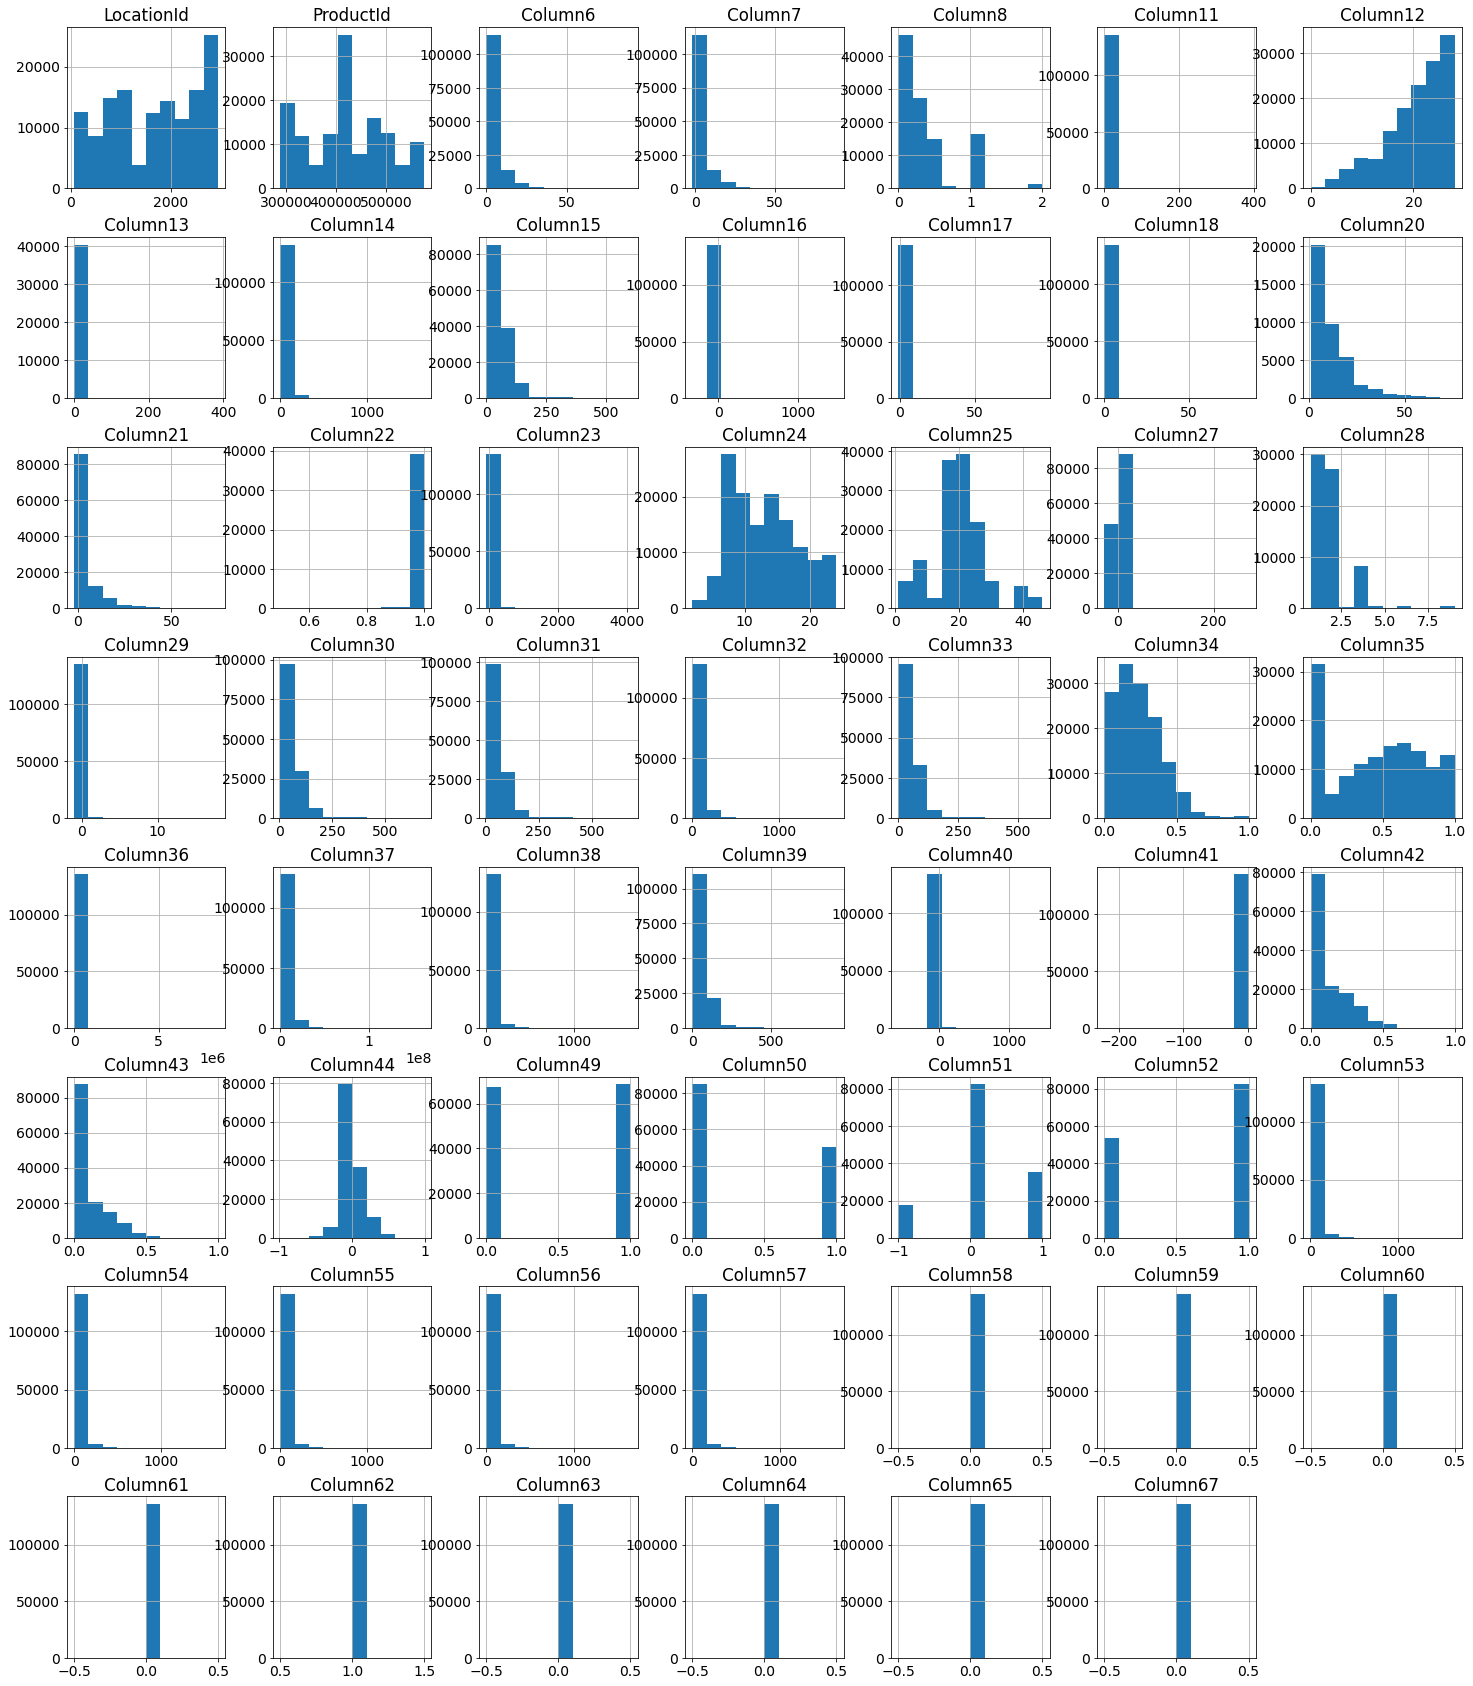

In [22]:
train_df.drop(columns=['ValidationDateTime', 'Target']).hist(figsize=(25, 30));

In [23]:
# Запрос к базе для форм. нового признака - суммарные продажи по месяцам

part_query = """
SELECT LocationId,
       ProductId,
       DATEPART(MONTH, Datetime) AS Month,
       SUM(Quantity) AS SumQ
FROM dbo.LocationStateHourSales AS l
WHERE l.Quantity >= 0
GROUP BY LocationId, ProductId, DATEPART(MONTH, Datetime)
ORDER BY LocationId, DATEPART(MONTH, Datetime)
"""

part_sales = pd.read_sql(part_query, conn)
part_sales

,LocationId,ProductId,Month,SumQ
0,63,297236,5,5.0000
1,63,463284,5,2.0000
2,63,467280,5,26.0000
3,63,575925,5,6.0000
4,63,355843,5,2.0000
...,...,...,...,...
4312567,2950,426593,8,2.0000
4312568,2950,314875,8,12.0000
4312569,2950,521617,8,7.0000
4312570,2950,309975,8,4.0000


In [24]:
# Формир. нового признака

train_df['Month'] = train_df['ValidationDateTime'].dt.month
train_df.head()

,LocationId,ProductId,ValidationDateTime,Column6,Column7,Column8,Column9,Column10,Column11,Column12,Column13,Column14,Column15,Column16,Column17,Column18,Column19,Column20,Column21,Column22,Column23,Column24,Column25,Column26,Column27,Column28,Column29,Column30,Column31,Column32,Column33,Column34,Column35,Column36,Column37,Column38,Column39,Column40,Column41,Column42,Column43,Column44,Column45,Column46,Column47,Column49,Column50,Column51,Column52,Column53,Column54,Column55,Column56,Column57,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67,Target,Month
117948,2718,558125,2023-06-01 14:44:35.147,1.0000,-1.0000,2.0000,None,None,2.3144,9,4.5443,121.8998,121.8998,0.0000,0.0000,2.0000,False,NaN,NaN,NaN,6.1400,24,41,None,4.7269,1.3810,0.1125,121.8868,121.7711,124.9010,117.8332,0.0566,0.0000,3355.3579,408585.5000,121.8998,117.8332,4.0666,0.0334,0.0240,0.0566,-0.0326,False,False,False,0.0000,0.0000,0.0000,1.0000,121.8998,121.8998,121.8998,121.8998,121.8998,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,None,0.0000,0,6
117815,2718,392473,2023-06-01 14:45:54.250,1.0000,-1.0000,2.0000,None,None,1.5714,11,3.0000,29.9925,29.9925,0.0000,0.0000,0.0000,False,NaN,NaN,NaN,11.0000,22,39,None,3.5493,1.5000,0.0887,29.9722,29.9642,29.9925,29.7920,0.0067,0.0000,44498.0000,1333347.3750,29.9925,29.9900,0.0025,0.0001,0.0000,0.0001,-0.0001,False,False,False,0.0000,0.0000,0.0000,1.0000,29.9925,29.9925,29.9925,29.9925,29.9925,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,None,0.0000,0,6
117813,2718,392392,2023-06-01 14:46:22.250,0.0000,-1.0000,NaN,None,None,5.5357,18,6.4000,36.4900,36.4900,0.0000,0.0000,0.0000,False,NaN,NaN,NaN,-2.0000,9,17,None,3.7059,1.8889,0.2059,36.8176,36.7759,38.9900,35.7125,0.0841,0.0000,149888.0000,5512260.0000,36.4900,36.4900,0.0000,0.0000,0.0641,0.0641,0.0000,False,False,False,0.0000,0.0000,0.0000,1.0000,36.4900,36.4900,36.4900,36.4900,36.4900,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,None,0.0000,0,6
117902,2718,495106,2023-06-01 14:49:22.857,4.0000,2.0000,0.5000,None,None,2.3214,7,2.0000,137.4617,137.4617,0.0000,0.0000,0.0000,True,NaN,-2.0000,NaN,17.0000,24,41,None,4.3278,NaN,0.1030,138.8159,138.9028,139.9000,135.1400,0.0340,0.6000,14950.0000,2076596.7500,137.4617,139.9000,-2.4383,-0.0177,0.0174,0.0000,0.0174,True,False,True,1.0000,0.0000,1.0000,0.0000,137.4617,137.4617,137.4617,137.4617,137.4617,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,None,0.0000,0,6
67140,1722,425684,2023-06-01 14:49:56.067,1.0000,0.0000,1.0000,None,None,1.6786,15,2.7333,39.9900,39.9900,0.0000,0.0000,2.0000,False,NaN,NaN,NaN,38.0000,17,27,None,2.0688,0.8571,0.0739,39.8716,39.9022,39.9900,39.0100,0.0245,0.0000,3321.0000,132515.1875,39.9900,39.9900,0.0000,0.0000,0.0000,0.0000,0.0000,False,False,False,0.0000,0.0000,0.0000,1.0000,39.9900,39.9900,39.9900,39.9900,39.9900,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,None,0.0000,0,6


In [25]:
# Объединение таблиц

merge_df = pd.merge(train_df, part_sales, how='left', on=['LocationId', 'ProductId', 'Month'])
merge_df.head(10)

,LocationId,ProductId,ValidationDateTime,Column6,Column7,Column8,Column9,Column10,Column11,Column12,Column13,Column14,Column15,Column16,Column17,Column18,Column19,Column20,Column21,Column22,Column23,Column24,Column25,Column26,Column27,Column28,Column29,Column30,Column31,Column32,Column33,Column34,Column35,Column36,Column37,Column38,Column39,Column40,Column41,Column42,Column43,Column44,Column45,Column46,Column47,Column49,Column50,Column51,Column52,Column53,Column54,Column55,Column56,Column57,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67,Target,Month,SumQ
0,2718,558125,2023-06-01 14:44:35.147,1.0000,-1.0000,2.0000,None,None,2.3144,9,4.5443,121.8998,121.8998,0.0000,0.0000,2.0000,False,NaN,NaN,NaN,6.1400,24,41,None,4.7269,1.3810,0.1125,121.8868,121.7711,124.9010,117.8332,0.0566,0.0000,3355.3579,408585.5000,121.8998,117.8332,4.0666,0.0334,0.0240,0.0566,-0.0326,False,False,False,0.0000,0.0000,0.0000,1.0000,121.8998,121.8998,121.8998,121.8998,121.8998,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,None,0.0000,0,6,50.5850
1,2718,392473,2023-06-01 14:45:54.250,1.0000,-1.0000,2.0000,None,None,1.5714,11,3.0000,29.9925,29.9925,0.0000,0.0000,0.0000,False,NaN,NaN,NaN,11.0000,22,39,None,3.5493,1.5000,0.0887,29.9722,29.9642,29.9925,29.7920,0.0067,0.0000,44498.0000,1333347.3750,29.9925,29.9900,0.0025,0.0001,0.0000,0.0001,-0.0001,False,False,False,0.0000,0.0000,0.0000,1.0000,29.9925,29.9925,29.9925,29.9925,29.9925,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,None,0.0000,0,6,46.0000
2,2718,392392,2023-06-01 14:46:22.250,0.0000,-1.0000,NaN,None,None,5.5357,18,6.4000,36.4900,36.4900,0.0000,0.0000,0.0000,False,NaN,NaN,NaN,-2.0000,9,17,None,3.7059,1.8889,0.2059,36.8176,36.7759,38.9900,35.7125,0.0841,0.0000,149888.0000,5512260.0000,36.4900,36.4900,0.0000,0.0000,0.0641,0.0641,0.0000,False,False,False,0.0000,0.0000,0.0000,1.0000,36.4900,36.4900,36.4900,36.4900,36.4900,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,None,0.0000,0,6,182.0000
3,2718,495106,2023-06-01 14:49:22.857,4.0000,2.0000,0.5000,None,None,2.3214,7,2.0000,137.4617,137.4617,0.0000,0.0000,0.0000,True,NaN,-2.0000,NaN,17.0000,24,41,None,4.3278,NaN,0.1030,138.8159,138.9028,139.9000,135.1400,0.0340,0.6000,14950.0000,2076596.7500,137.4617,139.9000,-2.4383,-0.0177,0.0174,0.0000,0.0174,True,False,True,1.0000,0.0000,1.0000,0.0000,137.4617,137.4617,137.4617,137.4617,137.4617,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,None,0.0000,0,6,42.0000
4,1722,425684,2023-06-01 14:49:56.067,1.0000,0.0000,1.0000,None,None,1.6786,15,2.7333,39.9900,39.9900,0.0000,0.0000,2.0000,False,NaN,NaN,NaN,38.0000,17,27,None,2.0688,0.8571,0.0739,39.8716,39.9022,39.9900,39.0100,0.0245,0.0000,3321.0000,132515.1875,39.9900,39.9900,0.0000,0.0000,0.0000,0.0000,0.0000,False,False,False,0.0000,0.0000,0.0000,1.0000,39.9900,39.9900,39.9900,39.9900,39.9900,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,None,0.0000,0,6,111.0000
5,1722,423850,2023-06-01 14:51:10.277,0.0000,-2.0000,NaN,None,None,0.6071,6,1.6667,64.9900,64.8350,0.1550,0.0024,2.0000,True,NaN,-2.0000,NaN,17.0000,21,42,None,1.0297,NaN,0.0239,87.2436,79.8073,109.9000,64.8350,0.4101,0.6667,10365.0000,827203.0000,64.9900,109.9000,-44.9100,-0.6910,0.4086,0.0000,0.4086,True,False,True,1.0000,0.0000,1.0000,0.0000,64.9900,64.9900,64.9900,64.9900,64.9900,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,None,0.0000,0,6,34.0000
6,1722,426157,2023-06-01 14:51:53.663,7.0000,6.0000,0.1429,None,None,4.8214,15,4.3636,19.9900,19.9900,0.0000,0.0000,0.0000,True,NaN,-1.0000,NaN,180.0000,12,22,None,5.4201,NaN,0.2357,22.3441,22.1828,23.9900,19.9900,0.1667,0.2941,36720.0000,814552.1875,19.9900,23.9000,-3.9100,-0.1956,0.1667,0.0038,0.1630,True,False,True,1.0000,0.0000,1.0000,0.0000,19.9900,19.9900,19.9900,19.9900,19.9900,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,None,0.0000,0,6,136.0000
7,713,485161,2023-06-01 14:51:59.317,18.0000,16.0000,0.1111,None,None,1.2857,6,NaN,43.7675,43.767

In [26]:
# проверка
train_df.shape, merge_df.shape

((135847, 66), (135847, 67))

In [27]:
# Аналогично для тестового набора данных

test_df['Month'] = test_df['ValidationDateTime'].dt.month
test_df.head()

,LocationId,ProductId,ValidationDateTime,Column6,Column7,Column8,Column9,Column10,Column11,Column12,Column13,Column14,Column15,Column16,Column17,Column18,Column19,Column20,Column21,Column22,Column23,Column24,Column25,Column26,Column27,Column28,Column29,Column30,Column31,Column32,Column33,Column34,Column35,Column36,Column37,Column38,Column39,Column40,Column41,Column42,Column43,Column44,Column45,Column46,Column47,Column49,Column50,Column51,Column52,Column53,Column54,Column55,Column56,Column57,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67,Month
0,63,288606,2023-07-25 14:57:04,14.0000,13.0000,0.0714,None,None,3.0714,15,NaN,29.9900,29.9900,0.0000,0.0000,1.0000,True,NaN,-1.0000,NaN,6.0000,14,23,None,3.9973,NaN,0.1666,28.5125,28.0891,29.9900,24.9900,0.1667,0.4825,19380.0000,544367.1875,29.9900,24.9900,5.0000,0.1667,0.0000,0.1667,-0.1667,True,False,True,1.0000,0.0000,1.0000,0.0000,29.9900,29.9900,29.9900,29.9900,29.9900,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0,None,0,7
1,63,288606,2023-08-03 14:58:53,2.0000,1.0000,0.5000,None,None,1.3929,11,NaN,29.9900,29.9900,0.0000,0.0000,1.0000,False,4.0000,3.0000,1.0000,22.0000,14,23,None,5.3786,1.2500,0.2241,28.1336,27.2465,29.9900,24.9900,0.1667,0.2179,13260.0000,361289.0938,29.9900,29.9900,0.0000,0.0000,0.0000,0.0000,0.0000,False,True,True,0.0000,1.0000,-1.0000,0.0000,29.9900,29.9900,29.9900,29.9900,29.9900,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0,None,0,8
2,63,288783,2023-07-24 14:57:11,4.0000,4.0000,0.0000,None,None,2.0000,16,NaN,99.9900,99.9900,0.0000,0.0000,1.0000,False,1.0000,1.0000,1.0000,8.0000,7,6,None,0.5577,3.2857,0.0797,101.0600,99.5792,119.9000,89.6633,0.2522,0.7879,1782.0000,177450.2031,99.9900,89.9900,10.0000,0.1000,0.1661,0.2495,-0.0834,True,False,True,1.0000,0.0000,1.0000,0.0000,99.9900,99.9900,99.9900,99.9900,99.9900,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0,None,0,7
3,63,288783,2023-08-03 14:57:39,0.0000,-1.0000,NaN,None,None,1.9643,18,NaN,99.9900,99.9900,0.0000,0.0000,1.0000,True,NaN,-1.0000,NaN,8.0000,16,25,None,1.8446,NaN,0.0709,99.4708,99.3834,108.9000,89.6633,0.1766,0.7463,1809.0000,179784.6250,99.9900,108.9000,-8.9100,-0.0891,0.0818,0.0000,0.0818,True,False,True,1.0000,0.0000,1.0000,0.0000,99.9900,99.9900,99.9900,99.9900,99.9900,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0,None,0,8
4,63,289136,2023-07-24 14:57:09,6.0000,6.0000,0.0000,None,None,1.3571,13,NaN,29.9900,29.9900,0.0000,0.0000,1.0000,True,NaN,0.0000,NaN,15.0000,7,6,None,1.8890,NaN,0.2699,29.2153,29.3562,29.9900,24.9900,0.1667,0.4894,7990.0000,234555.7969,29.9900,24.9900,5.0000,0.1667,0.0000,0.1667,-0.1667,True,True,False,1.0000,1.0000,0.0000,1.0000,29.9900,29.9900,29.9900,29.9900,29.9900,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0,None,0,7


In [28]:
# Объединение таблиц

merge_df_check = pd.merge(test_df, part_sales, how='left', on=['LocationId', 'ProductId', 'Month'])
merge_df_check.head(10)

,LocationId,ProductId,ValidationDateTime,Column6,Column7,Column8,Column9,Column10,Column11,Column12,Column13,Column14,Column15,Column16,Column17,Column18,Column19,Column20,Column21,Column22,Column23,Column24,Column25,Column26,Column27,Column28,Column29,Column30,Column31,Column32,Column33,Column34,Column35,Column36,Column37,Column38,Column39,Column40,Column41,Column42,Column43,Column44,Column45,Column46,Column47,Column49,Column50,Column51,Column52,Column53,Column54,Column55,Column56,Column57,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column66,Column67,Month,SumQ
0,63,288606,2023-07-25 14:57:04,14.0000,13.0000,0.0714,None,None,3.0714,15,NaN,29.9900,29.9900,0.0000,0.0000,1.0000,True,NaN,-1.0000,NaN,6.0000,14,23,None,3.9973,NaN,0.1666,28.5125,28.0891,29.9900,24.9900,0.1667,0.4825,19380.0000,544367.1875,29.9900,24.9900,5.0000,0.1667,0.0000,0.1667,-0.1667,True,False,True,1.0000,0.0000,1.0000,0.0000,29.9900,29.9900,29.9900,29.9900,29.9900,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0,None,0,7,83.0000
1,63,288606,2023-08-03 14:58:53,2.0000,1.0000,0.5000,None,None,1.3929,11,NaN,29.9900,29.9900,0.0000,0.0000,1.0000,False,4.0000,3.0000,1.0000,22.0000,14,23,None,5.3786,1.2500,0.2241,28.1336,27.2465,29.9900,24.9900,0.1667,0.2179,13260.0000,361289.0938,29.9900,29.9900,0.0000,0.0000,0.0000,0.0000,0.0000,False,True,True,0.0000,1.0000,-1.0000,0.0000,29.9900,29.9900,29.9900,29.9900,29.9900,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0,None,0,8,2.0000
2,63,288783,2023-07-24 14:57:11,4.0000,4.0000,0.0000,None,None,2.0000,16,NaN,99.9900,99.9900,0.0000,0.0000,1.0000,False,1.0000,1.0000,1.0000,8.0000,7,6,None,0.5577,3.2857,0.0797,101.0600,99.5792,119.9000,89.6633,0.2522,0.7879,1782.0000,177450.2031,99.9900,89.9900,10.0000,0.1000,0.1661,0.2495,-0.0834,True,False,True,1.0000,0.0000,1.0000,0.0000,99.9900,99.9900,99.9900,99.9900,99.9900,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0,None,0,7,64.0000
3,63,288783,2023-08-03 14:57:39,0.0000,-1.0000,NaN,None,None,1.9643,18,NaN,99.9900,99.9900,0.0000,0.0000,1.0000,True,NaN,-1.0000,NaN,8.0000,16,25,None,1.8446,NaN,0.0709,99.4708,99.3834,108.9000,89.6633,0.1766,0.7463,1809.0000,179784.6250,99.9900,108.9000,-8.9100,-0.0891,0.0818,0.0000,0.0818,True,False,True,1.0000,0.0000,1.0000,0.0000,99.9900,99.9900,99.9900,99.9900,99.9900,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0,None,0,8,6.0000
4,63,289136,2023-07-24 14:57:09,6.0000,6.0000,0.0000,None,None,1.3571,13,NaN,29.9900,29.9900,0.0000,0.0000,1.0000,True,NaN,0.0000,NaN,15.0000,7,6,None,1.8890,NaN,0.2699,29.2153,29.3562,29.9900,24.9900,0.1667,0.4894,7990.0000,234555.7969,29.9900,24.9900,5.0000,0.1667,0.0000,0.1667,-0.1667,True,True,False,1.0000,1.0000,0.0000,1.0000,29.9900,29.9900,29.9900,29.9900,29.9900,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0,None,0,7,37.0000
5,63,289579,2023-07-24 14:57:09,4.0000,3.0000,0.2500,None,None,6.2143,27,NaN,14.4900,14.4900,0.0000,0.0000,0.0000,False,NaN,NaN,NaN,88.0000,17,26,None,6.3478,1.0000,0.2351,14.2198,14.2031,14.4900,11.5440,0.2033,0.0000,62320.0000,885137.5000,14.4900,14.4900,-0.0000,-0.0000,0.0000,0.0000,0.0000,False,False,False,0.0000,0.0000,0.0000,1.0000,14.4900,14.4900,14.4900,14.4900,14.4900,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0,None,0,7,195.0000
6,63,289579,2023-07-26 14:57:03,6.0000,5.0000,0.1667,None,None,6.5000,27,NaN,14.4900,14.4900,0.0000,0.0000,0.0000,False,NaN,NaN,NaN,72.0000,12,21,None,5.8821,1.4545,0.2674,14.2162,14.2047,14.4900,11.5440,0.2033,0.0000,64944.0000,922513.1250,14.4900,11.5440,2.9460,0.2033,0.0000,0.2033,-0.2033,False,False,False,0.0000,0.0000,0.0000,1.0000,14.4900,14.4900,14.4900,14.4900,14.4900,0.0000,0.0000,0.0000,0.0000,1,0,0.0000,0,None,0,7,195.0000
7,63,289579,2023-08-01 14:57:07,3.0000,2.0000,0.3333,None,None,6.3929,27,NaN,14.4257,14.4257,0.0000,0.0000,0.0000,False,NaN,NaN,NaN,136.0000,10,19,None,5.3988,1.7000,0.2699,14.2200,14.2209,14.4900,11.5440,0.2033,0.0000,66256.0000,942222.6250,14.4257,14.4900,-0.0643,-0.0045,0.0044,0.0000,0.0044,False,False,False,0.0000,0.0000,0.0000,1.0000

In [29]:
# проверка
test_df.shape, merge_df_check.shape

((40771, 65), (40771, 66))

Посмотрим ещё раз на данные, удалим неинформативные признаки (исп. библиотека pandas-profiling):

* Признаки, чей тип не числовой

In [30]:
# Отберем признаки не числового типа

df_object = merge_df.select_dtypes(exclude=['int64', 'float64'])
df_object.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135847 entries, 0 to 135846
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   ValidationDateTime  135847 non-null  datetime64[ns]
 1   Column9             0 non-null       object        
 2   Column10            0 non-null       object        
 3   Column19            135847 non-null  bool          
 4   Column26            0 non-null       object        
 5   Column45            135846 non-null  object        
 6   Column46            135049 non-null  object        
 7   Column47            135846 non-null  object        
 8   Column66            0 non-null       object        
 9   Month               135847 non-null  int32         
dtypes: bool(1), datetime64[ns](1), int32(1), object(7)
memory usage: 8.9+ MB


In [31]:
# Есть признаки с одними только пропусками, удалим их из датасета, 
# в оставшихся - заполним пропуски

df_object.isna().sum()

ValidationDateTime         0
Column9               135847
Column10              135847
Column19                   0
Column26              135847
Column45                   1
Column46                 798
Column47                   1
Column66              135847
Month                      0
dtype: int64

In [32]:
# Удаляем признаки 9, 10, 26 и 66

merge_df.drop(columns=['Column9', 'Column10', 'Column26', 'Column66'], inplace=True)

In [33]:
# дублируем для тестового набора
merge_df_check.drop(columns=['Column9', 'Column10', 'Column26', 'Column66'], inplace=True)

In [34]:
merge_df.describe(include=['object', 'bool'])

,Column19,Column45,Column46,Column47
count,135847,135846,135049,135846
unique,2,2,2,2
top,True,True,False,False
freq,68646,68618,84867,83148


In [35]:
# Один признак булева типа, переведем в bool и остальные также

merge_df[['Column19', 'Column45', 'Column46', 'Column47']] = merge_df[['Column19', 'Column45', 'Column46', 'Column47']].astype(bool)

In [36]:
# дублируем для тестового набора
merge_df_check[['Column19', 'Column45', 'Column46', 'Column47']] = merge_df_check[['Column19', 'Column45', 'Column46', 'Column47']].astype(bool)

* Признаки, чей тип числовой

In [37]:
# Отберем признаки числового типа

df_numeric = merge_df.select_dtypes(include=['int32', 'int64', 'float64'])
df_numeric

,LocationId,ProductId,Column6,Column7,Column8,Column11,Column12,Column13,Column14,Column15,Column16,Column17,Column18,Column20,Column21,Column22,Column23,Column24,Column25,Column27,Column28,Column29,Column30,Column31,Column32,Column33,Column34,Column35,Column36,Column37,Column38,Column39,Column40,Column41,Column42,Column43,Column44,Column49,Column50,Column51,Column52,Column53,Column54,Column55,Column56,Column57,Column58,Column59,Column60,Column61,Column62,Column63,Column64,Column65,Column67,Target,Month,SumQ
0,2718,558125,1.0000,-1.0000,2.0000,2.3144,9,4.5443,121.8998,121.8998,0.0000,0.0000,2.0000,NaN,NaN,NaN,6.1400,24,41,4.7269,1.3810,0.1125,121.8868,121.7711,124.9010,117.8332,0.0566,0.0000,3355.3579,408585.5000,121.8998,117.8332,4.0666,0.0334,0.0240,0.0566,-0.0326,0.0000,0.0000,0.0000,1.0000,121.8998,121.8998,121.8998,121.8998,121.8998,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0,6,50.5850
1,2718,392473,1.0000,-1.0000,2.0000,1.5714,11,3.0000,29.9925,29.9925,0.0000,0.0000,0.0000,NaN,NaN,NaN,11.0000,22,39,3.5493,1.5000,0.0887,29.9722,29.9642,29.9925,29.7920,0.0067,0.0000,44498.0000,1333347.3750,29.9925,29.9900,0.0025,0.0001,0.0000,0.0001,-0.0001,0.0000,0.0000,0.0000,1.0000,29.9925,29.9925,29.9925,29.9925,29.9925,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0,6,46.0000
2,2718,392392,0.0000,-1.0000,NaN,5.5357,18,6.4000,36.4900,36.4900,0.0000,0.0000,0.0000,NaN,NaN,NaN,-2.0000,9,17,3.7059,1.8889,0.2059,36.8176,36.7759,38.9900,35.7125,0.0841,0.0000,149888.0000,5512260.0000,36.4900,36.4900,0.0000,0.0000,0.0641,0.0641,0.0000,0.0000,0.0000,0.0000,1.0000,36.4900,36.4900,36.4900,36.4900,36.4900,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0,6,182.0000
3,2718,495106,4.0000,2.0000,0.5000,2.3214,7,2.0000,137.4617,137.4617,0.0000,0.0000,0.0000,NaN,-2.0000,NaN,17.0000,24,41,4.3278,NaN,0.1030,138.8159,138.9028,139.9000,135.1400,0.0340,0.6000,14950.0000,2076596.7500,137.4617,139.9000,-2.4383,-0.0177,0.0174,0.0000,0.0174,1.0000,0.0000,1.0000,0.0000,137.4617,137.4617,137.4617,137.4617,137.4617,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0,6,42.0000
4,1722,425684,1.0000,0.0000,1.0000,1.6786,15,2.7333,39.9900,39.9900,0.0000,0.0000,2.0000,NaN,NaN,NaN,38.0000,17,27,2.0688,0.8571,0.0739,39.8716,39.9022,39.9900,39.0100,0.0245,0.0000,3321.0000,132515.1875,39.9900,39.9900,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,39.9900,39.9900,39.9900,39.9900,39.9900,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0,6,111.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135842,2056,489873,2.0000,1.0000,0.5000,2.4286,25,2.4667,99.9900,99.9900,0.0000,0.0000,2.0000,NaN,NaN,NaN,5.0000,24,23,2.6328,1.1667,0.1097,97.1228,96.7846,99.9900,88.3400,0.1165,0.0000,144649.0000,13999789.0000,99.9900,98.9900,1.0000,0.0100,0.0000,0.0100,-0.0100,0.0000,0.0000,0.0000,1.0000,99.9900,99.9900,99.9900,99.9900,99.9900,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1,7,109.0000
135843,2022,440169,3.0000,3.0000,0.0000,16.2143,26,15.5556,64.7675,64.7675,0.0000,0.0000,0.0000,NaN,NaN,NaN,47.0000,6,5,4.5768,3.6667,0.7628,69.3590,69.1325,72.9900,64.7675,0.1127,0.0000,137535.0000,9508136.0000,64.7675,72.9433,-8.1758,-0.1262,0.1127,0.0006,0.1120,0.0000,0.0000,0.0000,1.0000,64.7675,64.7675,64.7675,64.7675,64.7675,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1,7,402.0000
135844,1788,426699,3.0000,2.0000,0.3333,7.7500,21,6.1667,17.9900,17.9900,0.0000,0.0000,2.0000,NaN,-1.0000,NaN,80.0000,16,24,9.5326,NaN,0.3813,17.3349,17.2155,17.9900,14.7500,0.1801,0.6478,133380.0000,2296204.2500,17.9900,17.9900,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,1.0000,17.9900,17.9900,17.9900,17.9900,17.9900,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1,7,214.0000

In [38]:
# Тут формируется отчёт, закомментировала, чтобы далее этот процесс не отнимал время

# Создаём отчёт
#profile = df_numeric.profile_report(title='Pandas_profiling_report', progress_bar=True, minimal=True, 
                                    #correlations={'pearson': {'calculate': True, 'warn_high_correlations': True}})

# Сохраняем отчёт в HTML формате
#profile.to_file("numeric_report.html")

In [39]:
# Есть столбцы с одним значением, удалим их

merge_df.drop(columns=['Column58', 'Column59', 'Column60', 'Column61', 'Column62', 'Column63',
                            'Column64', 'Column65', 'Column67'], inplace=True)

In [40]:
# дублируем для тестового набора
merge_df_check.drop(columns=['Column58', 'Column59', 'Column60', 'Column61', 'Column62', 'Column63',
                            'Column64', 'Column65', 'Column67'], inplace=True)

* Работа с пропусками

In [41]:
# Отдельно работаем с пропусками в кат. и чис. признаках

num_features = merge_df.select_dtypes(include=['int32', 'int64', 'float64']).columns.to_list()
cat_features = merge_df.select_dtypes(include=['bool']).columns.to_list()

In [42]:
merge_df[cat_features].isna().sum()

Column19    0
Column45    0
Column46    0
Column47    0
dtype: int64

In [43]:
# Заполним пропуски
# для заполнения пропусков в признаках не числового типа исп. стратегию - заполнить наиболее часто встр. значением.
# на обучении

for el in cat_features:
    merge_df[el] = merge_df[el].fillna(merge_df[el].mode()[0])
    
merge_df[cat_features].isna().sum()

Column19    0
Column45    0
Column46    0
Column47    0
dtype: int64

In [44]:
# на тесте исп. данные с обучения
for el in cat_features:
    merge_df_check[el] = merge_df_check[el].fillna(merge_df[el].mode()[0])
    
merge_df_check[cat_features].isna().sum()

Column19    0
Column45    0
Column46    0
Column47    0
dtype: int64

In [45]:
merge_df[num_features].isna().sum()

LocationId        0
ProductId         0
Column6           0
Column7           0
Column8       28017
Column11          0
Column12          0
Column13      95281
Column14          1
Column15         34
Column16         34
Column17         34
Column18         34
Column20      95971
Column21      27325
Column22      95971
Column23         23
Column24          0
Column25          0
Column27        180
Column28      68646
Column29        180
Column30          1
Column31          1
Column32          1
Column33          1
Column34          1
Column35          1
Column36          1
Column37          1
Column38          1
Column39        797
Column40        797
Column41        797
Column42          1
Column43        797
Column44        797
Column49          1
Column50        798
Column51        798
Column52          1
Column53          1
Column54          1
Column55          1
Column56          1
Column57          1
Target            0
Month             0
SumQ             12
dtype: int64

In [46]:
# Удалим признаки с большим числом пропусков

merge_df.drop(columns=['Column8', 'Column13', 'Column20', 'Column21', 'Column22', 'Column28'], inplace=True)

In [47]:
# дублируем для тестового набора
merge_df_check.drop(columns=['Column8', 'Column13', 'Column20', 'Column21', 'Column22', 'Column28'], inplace=True)

In [48]:
# Формируем списки признаков по типам
# Месяц не включаем в список катег. переменных

numerical_features = merge_df.select_dtypes(include=['int32', 'int64', 'float64']).columns.to_list()
numerical_features.remove('Target')
numerical_features.remove('LocationId')
numerical_features.remove('ProductId')
numerical_features.remove('Month')

In [49]:
categorical_features = merge_df.select_dtypes(include=['bool']).columns.to_list() + ['LocationId', 'ProductId']

In [50]:
display(numerical_features, categorical_features)

['Column6',
 'Column7',
 'Column11',
 'Column12',
 'Column14',
 'Column15',
 'Column16',
 'Column17',
 'Column18',
 'Column23',
 'Column24',
 'Column25',
 'Column27',
 'Column29',
 'Column30',
 'Column31',
 'Column32',
 'Column33',
 'Column34',
 'Column35',
 'Column36',
 'Column37',
 'Column38',
 'Column39',
 'Column40',
 'Column41',
 'Column42',
 'Column43',
 'Column44',
 'Column49',
 'Column50',
 'Column51',
 'Column52',
 'Column53',
 'Column54',
 'Column55',
 'Column56',
 'Column57',
 'SumQ']

['Column19', 'Column45', 'Column46', 'Column47', 'LocationId', 'ProductId']

## Подготовка данных

In [51]:
# Просмотр кол-ва признаков

display(len(numerical_features), len(categorical_features))

39

6

In [52]:
# Сохраним признаки и целевой признак (далее ц.п.) в отдельных переменных
# Введём обозначения: X - признаки, y - ц.п. (по аналогии с обозначениями выборок)

X_merge = merge_df.drop(columns=['ValidationDateTime', 'Month', 'Target']) # извлекаем признаки
y_merge = merge_df['Target'] # извлекаем целевой признак

# Проверка

display(X_merge.shape, y_merge.shape)

(135847, 45)

(135847,)

In [53]:
# Для формирования файла с предсказаниями - submission

X_test = merge_df_check.drop(columns=['ValidationDateTime', 'Month'])

# Проверка

display(X_test.shape)

(40771, 45)

## Построение модели

#### Модель LGBMClassifier 

In [54]:
# на 5 фолдах
fit_params={'categorical_feature': categorical_features}

lgbm_model = LGBMClassifier(random_state=STATE, class_weight='balanced')
lgbm_params = {'n_estimators': np.arange(80, 151, 10),
               'max_depth': np.arange(12, 16),
               'learning_rate': [0.035, 0.04]} 

In [55]:
%%time  

lgbm, lgbm_best_params, lgbm_score = best_model_params(lgbm_model, lgbm_params, X_merge, y_merge)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
CPU times: total: 41.7 s
Wall time: 25min 4s


In [56]:
print('Параметры "лучшей" модели ', lgbm_best_params)
print('Значение метрики качества: ', round(lgbm_score, 4))

Параметры "лучшей" модели  {'learning_rate': 0.035, 'max_depth': 14, 'n_estimators': 90}
Значение метрики качества:  0.6648


In [57]:
print_result(RESULTS)

,model,model_params,ROC-AUC
0,"LGBMClassifier(class_weight='balanced', learning_rate=0.035, max_depth=14,\n n_estimators=90, random_state=5962)","{'learning_rate': 0.035, 'max_depth': 14, 'n_estimators': 90}",0.6648


## Получение предсказаний выбранной модели

In [58]:
probabilities_one_test = lgbm.predict_proba(X_test)[:, 1]

In [59]:
submission = merge_df_check[['LocationId', 'ProductId', 'ValidationDateTime']].reset_index(drop=True)

In [60]:
submission['CalculatedProbability'] = probabilities_one_test

In [61]:
submission

,LocationId,ProductId,ValidationDateTime,CalculatedProbability
0,63,288606,2023-07-25 14:57:04,0.6716
1,63,288606,2023-08-03 14:58:53,0.5968
2,63,288783,2023-07-24 14:57:11,0.5919
3,63,288783,2023-08-03 14:57:39,0.6026
4,63,289136,2023-07-24 14:57:09,0.4083
...,...,...,...,...
40766,2950,572875,2023-07-26 15:01:26,0.5921
40767,2950,574768,2023-07-31 15:07:00,0.6217
40768,2950,576631,2023-07-26 15:01:27,0.8336
40769,2950,576631,2023-07-28 15:04:19,0.8511


In [62]:
# Сохраняем предсказания

submission.to_csv('Мастера Данных_1.csv', sep=';', decimal='.', index=False)